# **Analisis dan Klasifikasi Potensi Keuangan UMKM dengan Data Mining**

Tujuan Penelitian / Proyek:
1. Mengklasifikasikan Potensi Keuangan UMKM
Dengan memanfaatkan teknik data mining (seperti LightGBM, TabNet, EBM), kamu membangun model klasifikasi yang mengelompokkan UMKM ke dalam kategori potensi keuangan: Tinggi, Sedang, atau Rendah. Ini bertujuan untuk:
•	Mengukur performa keuangan berdasarkan variabel seperti aset, omset, laba, jumlah tenaga kerja, dll.
2. Memberikan Rekomendasi untuk Stakeholder
Hasil klasifikasi dipakai untuk:
•	Membantu pemerintah dalam menyalurkan bantuan atau program pendampingan.
•	Membantu lembaga keuangan menilai kelayakan UMKM untuk pendanaan.
•	Membantu investor dalam mengidentifikasi UMKM potensial untuk investasi.
3. Mengungkap Insight melalui Analisis Data
Sebelum klasifikasi, kamu juga:
•	Melakukan analisis eksplorasi data (EDA) untuk memahami kondisi UMKM.
•	Menggali insight seperti tren legalitas, rata-rata laba, distribusi aset, dan lainnya.
4. Memberikan Rekomendasi Otomatis
Notebook juga menyertakan logika untuk menghasilkan rekomendasi berbasis prediksi potensi, contohnya:
•	UMKM dengan potensi rendah → butuh pendampingan
•	UMKM dengan potensi tinggi → layak diberi investasi atau bantuan lanjutan

Dataset public askes at (https://www.kaggle.com/datasets/arumraa/dataset-umkm)

## Import Library

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

## Load Dataset

In [3]:
df = pd.read_csv('/kaggle/input/dataset-umkm/dataset_umkm.csv')

## Initial Data Exploration

In [4]:
print("🟢 5 Data Teratas:")
display(df.head())

🟢 5 Data Teratas:


,id_umkm,nama_usaha,jenis_usaha,tenaga_kerja_perempuan,tenaga_kerja_laki_laki,aset,omset,marketplace,kapasitas_produksi,status_legalitas,tahun_berdiri,laba,biaya_karyawan,jumlah_pelanggan
0,28828567,UD. Alif Pamungkas,Kesehatan,1,56,5497149,3347794,Tokopedia,479,Belum Terdaftar,2015,-2149355,171000000,479
1,28828568,UD. Zidanar Panji,Perdagangan,5,44,7398384,39969661,Bukalapak,464,Terdaftar,2014,32571277,147000000,464
2,28828569,UD. Winda Jayengprana,unknown,74,51,8881762,25253355,Website Sendiri,383,Belum Terdaftar,2000,16371593,375000000,383
3,28828570,UD. Damaris Satria,Jasa,89,5,9576178,20700389,Website Sendiri,986,Belum Terdaftar,2003,11124211,282000000,986
4,28828571,UD. Qasya Wiratama,Jasa,91,59,9456853,4820810,Lazada,314,Belum Terdaftar,2002,-4636043,450000000,314


In [5]:
print("\n🔵 Info Tipe Data:")
print(df.dtypes)


🔵 Info Tipe Data:
id_umkm                   object
nama_usaha                object
jenis_usaha               object
tenaga_kerja_perempuan    object
tenaga_kerja_laki_laki    object
aset                      object
omset                     object
marketplace               object
kapasitas_produksi        object
status_legalitas          object
tahun_berdiri             object
laba                      object
biaya_karyawan            object
jumlah_pelanggan          object
dtype: object


In [6]:
print("\n🟠 Jumlah Missing Value per Kolom:")
print(df.isnull().sum())


🟠 Jumlah Missing Value per Kolom:
id_umkm                    97
nama_usaha                  0
jenis_usaha                97
tenaga_kerja_perempuan    120
tenaga_kerja_laki_laki    102
aset                      111
omset                     113
marketplace               117
kapasitas_produksi        122
status_legalitas           94
tahun_berdiri              95
laba                      112
biaya_karyawan             95
jumlah_pelanggan          111
dtype: int64


## Data Cleaning and Preprocessing

In [7]:
df['jenis_usaha'] = df['jenis_usaha'].fillna('lainnya').replace('unknown', 'lainnya')

df['status_legalitas'] = df['status_legalitas'].map({'Terdaftar':1, 'Belum Terdaftar':0})

num_cols = ['tenaga_kerja_perempuan', 'tenaga_kerja_laki_laki', 'aset', 'omset', 'kapasitas_produksi', 
            'tahun_berdiri', 'laba', 'biaya_karyawan', 'jumlah_pelanggan']

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].median())

if 'marketplace' in df.columns:
    df = pd.get_dummies(df, columns=['marketplace'], drop_first=True)

## Feature Engineering

In [8]:
df['tenaga_kerja_total'] = df['tenaga_kerja_perempuan'] + df['tenaga_kerja_laki_laki']

def classify_potensi(laba):
    if laba < 0:
        return 'rendah'
    elif laba < 10000000:
        return 'sedang'
    else:
        return 'tinggi'

df['potensi_keuangan'] = df['laba'].apply(classify_potensi)

le = LabelEncoder()
df['potensi_keuangan_encoded'] = le.fit_transform(df['potensi_keuangan'])


## Pemilihan Fitur Untuk Model

In [9]:
fitur = ['tenaga_kerja_total', 'aset', 'omset', 'kapasitas_produksi', 'status_legalitas', 
         'tahun_berdiri', 'biaya_karyawan', 'jumlah_pelanggan'] + \
        [col for col in df.columns if col.startswith('marketplace_')]

X = df[fitur]
y = df['potensi_keuangan_encoded']

## Split data Training dan Testing

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Training model LIGHTGBM

In [11]:
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1451
[LightGBM] [Info] Number of data points in the train set: 10851, number of used features: 13
[LightGBM] [Info] Start training from score -2.432398
[LightGBM] [Info] Start training from score -1.609991
[LightGBM] [Info] Start training from score -0.339278


LGBMClassifier(random_state=42)

## Evaluasi Model

In [12]:
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Classification Report:
              precision    recall  f1-score   support

      rendah       0.96      0.97      0.97       239
      sedang       0.96      0.98      0.97       542
      tinggi       1.00      0.99      0.99      1932

    accuracy                           0.99      2713
   macro avg       0.97      0.98      0.98      2713
weighted avg       0.99      0.99      0.99      2713



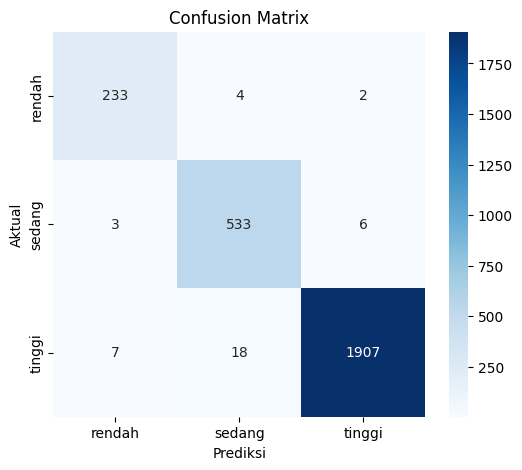

In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

## Interpretasi dan rekomendasi untuk UMKM

In [15]:
def rekomendasi_umkm(row):
    potensi = le.inverse_transform([row['potensi_keuangan_encoded']])[0]
    legal = row['status_legalitas']

    if potensi == 'rendah' and legal == 0:
        return "Pendampingan legalisasi usaha dan pelatihan manajemen keuangan."
    elif potensi == 'sedang' and row['tenaga_kerja_total'] > 20:
        return "Akses permodalan mikro dan peningkatan kapasitas produksi."
    elif potensi == 'tinggi':
        return "Dorongan investasi dan ekspansi usaha agar lebih berkembang."
    else:
        return "Pendampingan umum dan monitoring usaha."

df['rekomendasi'] = df.apply(rekomendasi_umkm, axis=1)

In [16]:
print("\n🟠 Beberapa Hasil rekomendasi UMKM:")
display(df[['id_umkm', 'nama_usaha', 'potensi_keuangan', 'rekomendasi']].head(10))


🟠 Beberapa Hasil rekomendasi UMKM:


,id_umkm,nama_usaha,potensi_keuangan,rekomendasi
0,28828567,UD. Alif Pamungkas,rendah,Pendampingan legalisasi usaha dan pelatihan ma...
1,28828568,UD. Zidanar Panji,tinggi,Dorongan investasi dan ekspansi usaha agar leb...
2,28828569,UD. Winda Jayengprana,tinggi,Dorongan investasi dan ekspansi usaha agar leb...
3,28828570,UD. Damaris Satria,tinggi,Dorongan investasi dan ekspansi usaha agar leb...
4,28828571,UD. Qasya Wiratama,rendah,Pendampingan legalisasi usaha dan pelatihan ma...
5,28828572,UD. Grego Wiraatmaja Nara,tinggi,Dorongan investasi dan ekspansi usaha agar leb...
6,28828573,UD. Mika Bagaskara,rendah,Pendampingan umum dan monitoring usaha.
7,28828574,UD. Yora Selaras,sedang,Akses permodalan mikro dan peningkatan kapasit...
8,28828575,UD. Wenny Langit,tinggi,Dorongan investasi dan ekspansi usaha agar leb...
9,28828576,UD. Fani Wijaya,tinggi,Dorongan investasi dan ekspansi usaha agar leb...


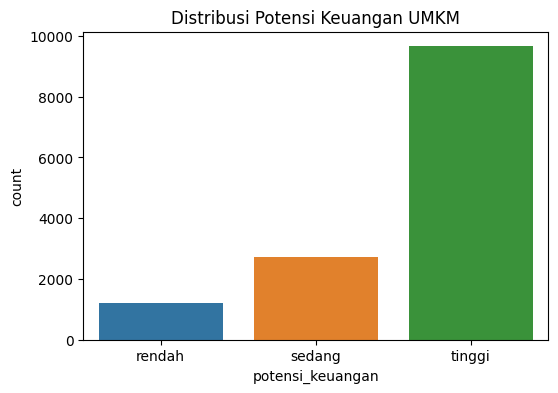

In [17]:
plt.figure(figsize=(6,4))
sns.countplot(x='potensi_keuangan', data=df, order=['rendah', 'sedang', 'tinggi'])
plt.title('Distribusi Potensi Keuangan UMKM')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


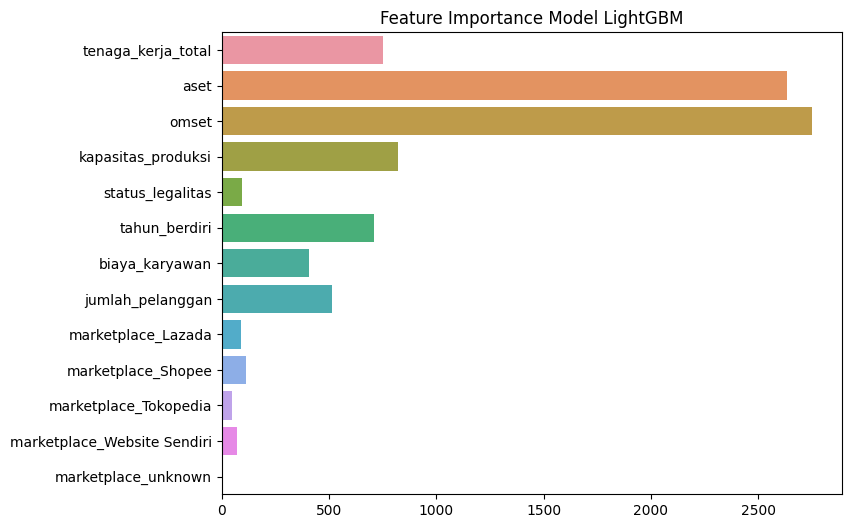

In [18]:
importances = model.feature_importances_
plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=fitur)
plt.title('Feature Importance Model LightGBM')
plt.show()

## Rekomendasi Sistem

In [21]:
df_potensi_tinggi = df[df['potensi_keuangan'] == 'tinggi'].copy()
df_potensi_tinggi = df_potensi_tinggi.sort_values(by='omset', ascending=False)

top_10_umkm = df_potensi_tinggi[['id_umkm', 'nama_usaha', 'potensi_keuangan', 'omset', 'aset', 'laba', 'rekomendasi']].head(10)

print("\n=== TOP 10 REKOMENDASI SISTEM (UMKM POTENSI TINGGI) ===")
display(top_10_umkm)


=== TOP 10 REKOMENDASI SISTEM (UMKM POTENSI TINGGI) ===


,id_umkm,nama_usaha,potensi_keuangan,omset,aset,laba,rekomendasi
13009,288221576,UD. Alvino Manggala,tinggi,49999699.0,9479034.0,40520665.0,Dorongan investasi dan ekspansi usaha agar leb...
2810,288211377,UD. Yessi Mulyo,tinggi,49996606.0,6146620.0,43849986.0,Dorongan investasi dan ekspansi usaha agar leb...
5953,288214520,UD. Tariq Naraya,tinggi,49994521.0,5730252.0,44264269.0,Dorongan investasi dan ekspansi usaha agar leb...
8689,288217256,UD. Tama Manunggal Hilmiyah,tinggi,49991716.0,3751311.0,46240405.0,Dorongan investasi dan ekspansi usaha agar leb...
11118,288219685,UD. Ari Wisesa,tinggi,49991600.0,3132589.0,46859011.0,Dorongan investasi dan ekspansi usaha agar leb...
10139,288218706,UD. Wawan Sundawa,tinggi,49990901.0,9725935.0,40264966.0,Dorongan investasi dan ekspansi usaha agar leb...
5022,288213589,UD. Via Langit,tinggi,49990394.0,8824349.0,41166045.0,Dorongan investasi dan ekspansi usaha agar leb...
3509,288212076,UD. Erlin Senja,tinggi,49989193.0,9475584.0,40513609.0,Dorongan investasi dan ekspansi usaha agar leb...
12158,288220725,UD. Cakra Indah,tinggi,49987887.0,2995667.0,46992220.0,Dorongan investasi dan ekspansi usaha agar leb...
9009,288217576,UD. Qyla Galang,tinggi,49981470.0,8194415.0,41787055.0,Dorongan investasi dan ekspansi usaha agar leb...


## Simpan Hasil

In [22]:
df[['id_umkm', 'nama_usaha', 'potensi_keuangan', 'rekomendasi']].to_csv('hasil_klasifikasi_umkm.csv', index=False)
print("File hasil_klasifikasi_umkm.csv berhasil disimpan.")

File hasil_klasifikasi_umkm.csv berhasil disimpan.
